# 一元配置分散分析
[やること」
- QQ plot
- One way anova
- 多重比較
- 棒グラフの作成と95%ciの計算

In [1]:
import os
from typing import Dict, NamedTuple, Tuple, Union
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm

from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
class Config(NamedTuple):
    data: str = "../preliminary.csv"
    dirctory: str = "../images/anova"
    savefile: bool = False
    kwarg_savefig: Dict[str, Union[str, int, float]] = {
        "facecolor": "white",
        "dpi": 300,
        "bbox_inches": "tight",
        "pad_inches": 0.05
    }

In [3]:
conf = Config(savefile=True)

In [4]:
os.makedirs(conf.dirctory, exist_ok=True)

In [5]:
# load result data

res = pd.read_csv(conf.data, index_col=0)
res

,1.0,1.5,2.0,2.5,2.97
Num of trial,,,,,
0,4.94,5.68,5.13,6.55,5.36
1,5.22,5.67,5.81,4.81,5.34
2,4.14,5.72,6.83,7.10,6.10
3,5.46,6.04,5.59,6.73,5.62
4,5.18,6.23,6.28,8.21,5.50


---
## QQ plot

/opt/conda/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/opt/conda/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/opt/conda/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/opt/conda/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> mar

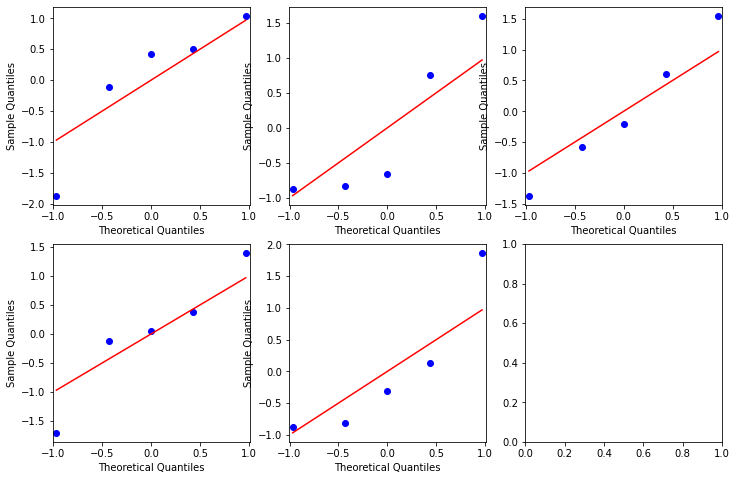

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for i in range(res.shape[1]):
    sm.qqplot(res.iloc[:,i], st.t, distargs=(4,), fit=True, line="s", ax=ax[i//3, i%3])

- 正規分布してなさそうな気もするけど、目を瞑っておく

---
## One way anova

In [7]:
anova_res = {
    "size": st.f_oneway(*[res.iloc[:, i] for i in range(res.shape[1])]),
    "batch": st.f_oneway(*[res.iloc[i, :] for i in range(res.shape[0])])
}

---
## Pairwise Turkey

In [8]:
# reshape res matrix

batch = pd.Series([i // 5 + 1 for i in np.arange(25)])
size = pd.Series([1, 1.5, 2, 2.5, 2.97]*5)

df = pd.DataFrame(res.values.reshape(-1, 1), columns=["time"]).assign(batch=batch, size=size)

In [9]:
df.head(6)

,time,batch,size
0,4.94,1,1.00
1,5.68,1,1.50
2,5.13,1,2.00
3,6.55,1,2.50
4,5.36,1,2.97
5,5.22,2,1.00


In [10]:
def turkey_asterisk(
    endog: pd.core.series.Series,
    group: pd.core.series.Series,
    ax,
    alpha: float = 0.05
):
    marker = lambda p: "$*$" if p >= 0.01 \
    else "$**$" if p >= 0.001 else "$***$"
    label = lambda p: "$p<0.05$" if p >= 0.01 \
    else "$p<0.01$" if p >= 0.001 else "$p<0.001$"
    
    res = pairwise_tukeyhsd(endog, group, alpha)
    if True in res.reject:
        idx = [i for i, v in enumerate(res.reject.tolist()) if v == True]
        
        for iteration, index in enumerate(idx):
            pair = list(combinations(group.unique(), 2))[index]
            group1, group2 = [
                group.unique().tolist().index(v) for v in pair
            ]
            ax.plot(
                np.linspace(group1, group2, 2),
                (np.ceil(endog.max()) + iteration) * np.ones(2),
                c="k"
            )
            ax.scatter(
                np.mean([group1, group2]),
                np.ceil(endog.max()) + iteration + 0.5,
                marker=marker(res.pvalues[index]), s=100,
                label=label(res.pvalues[index]) + "\n$(Turkey's$ $HSD)$",
                c="k"
            ) 

---
## Barplot & 95%ci

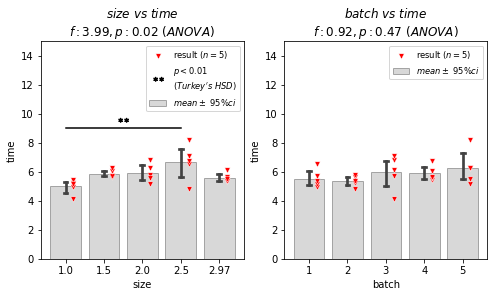

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

label = "$mean \pm$ 95" + "%" + "$ci$"

for i, value in enumerate(["size",  "batch"]):
    sns.barplot(
        data=df, x=value, y="time",
        color="gray", ci=95, label=label,
        capsize=0.1, ax=ax[i], alpha=0.3,
        edgecolor="k"
    )
    
    sns.scatterplot(
        data=df,
        x=[df.index%5 + 0.2, df.index//5 + 0.2][i],
        y="time", ax=ax[i], marker="v", color="r",
        **{"zorder":3, "s":30}, alpha=1, label="result ($n=5$)"
    )
    
    turkey_asterisk(df.time, df.loc[:, value], ax[i])
    
    title = f"${value}$ $vs$ $time$\n$f:" \
    + f"{anova_res[value][0].round(2)}" + \
    f", p: {anova_res[value][1].round(2)}$ $(ANOVA)$"

    ax[i].legend(fontsize="small")
    ax[i].set_ylim([0, 15])
    ax[i].set_title(title)

if conf.savefile:
    plt.savefig(f"{conf.dirctory}/bar.png", **conf.kwarg_savefig)